# Inverse model on FetchNoTask

## Instanciate and train the model

Create the environment.

In [33]:
import gym
import gym_robotics
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage
from go_explore.utils import AtariWrapper

n_envs = 3

env = VecTransposeImage(
    make_vec_env(
        "FetchNoTask-v1",
        n_envs=n_envs,
        env_kwargs=dict(image_obs_space=True),
    )
)

Display an observation.

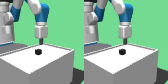

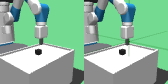

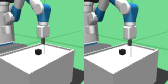

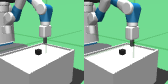

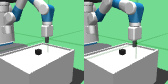

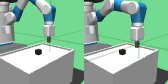

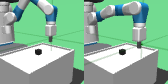

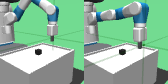

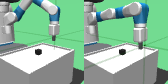

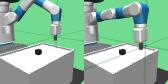

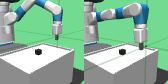

In [34]:
from PIL import Image
import numpy as np
from IPython.display import display

obs = env.reset()
img = Image.fromarray(np.hstack(np.moveaxis(obs, -3, -1)))
display(img)

actions = [
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
]
actions = np.array(actions)

for _ in range(10):
    obs, reward, done, info = env.step(actions)
    img = Image.fromarray(np.hstack(np.moveaxis(obs, -3, -1)))
    display(img)



Initilize the device.

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Create a buffer and feed it.

In [4]:
import numpy as np

from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.vec_env import VecEnv

from copy import deepcopy


def collect_rollouts(n, env, replay_buffer):
    num_timesteps = 0
    last_obs = env.reset()
    while num_timesteps < n:
        # Select action randomly or according to policy
        action = np.array([env.action_space.sample() for _ in range(env.num_envs)])

        # Rescale and perform action
        new_obs, rewards, dones, infos = env.step(action)

        num_timesteps += env.num_envs
        # Avoid modification by reference
        next_obs = deepcopy(new_obs)

        # As the VecEnv resets automatically, new_obs is already the
        # first observation of the next episode
        for i, done in enumerate(dones):
            if done and infos[i].get("terminal_observation") is not None:
                next_obs[i] = infos[i]["terminal_observation"]

        replay_buffer.add(
            last_obs,
            next_obs,
            action,
            rewards,
            dones,
            infos,
        )

        last_obs = new_obs


train_buffer = ReplayBuffer(
    10_000,
    env.observation_space,
    env.action_space,
    n_envs=n_envs,
    device=device,
)
test_buffer = ReplayBuffer(
    1_000,
    env.observation_space,
    env.action_space,
    n_envs=n_envs,
    device=device,
)

collect_rollouts(10_000, env, train_buffer)
collect_rollouts(1_000, env, test_buffer)


In [5]:
train_buffer.pos

0

Instanciate the model and the optimizer.

In [6]:
from go_explore.inverse_model import ConvInverseModel

from torch import optim

inverse_model = ConvInverseModel(action_size=env.action_space.shape[0], latent_size=32).to(device)
optimizer = optim.Adam(inverse_model.parameters(), lr=1e-3)

Train the model.

In [7]:
import torch.nn.functional as F


for epoch in range(10_000):
    # Sample
    sample = train_buffer.sample(32)
    observations = sample.observations.float() / 255
    next_observations = sample.next_observations.float() / 255
    actions = sample.actions

    # Compute the output image
    inverse_model.train()
    pred_actions = inverse_model(observations, next_observations)

    # Compute the loss
    loss = F.mse_loss(pred_actions, actions)

    # Step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        sample = test_buffer.sample(32)
        observations = sample.observations.float() / 255
        next_observations = sample.next_observations.float() / 255
        actions = sample.actions

        # Compute the output image
        inverse_model.eval()
        pred_actions = inverse_model(observations, next_observations)
        # Compute the loss
        test_loss = F.mse_loss(pred_actions, actions)
        print("epoch: {:5d}\tprediction loss: train {:.5f}, test: {:.5f} ".format(epoch, loss.item(), test_loss.item()))


epoch:     0	prediction loss: train 0.32882, test: 0.29225 
epoch:   500	prediction loss: train 0.17100, test: 0.17716 
epoch:  1000	prediction loss: train 0.18077, test: 0.15271 
epoch:  1500	prediction loss: train 0.14365, test: 0.14947 
epoch:  2000	prediction loss: train 0.11084, test: 0.15354 
epoch:  2500	prediction loss: train 0.10035, test: 0.10410 
epoch:  3000	prediction loss: train 0.12446, test: 0.11731 


KeyboardInterrupt: 

See the result for one transition.

true action		 tensor([[ 0.7304,  0.3113, -0.8948, -0.4978]], device='cuda:0')
predicted action	 tensor([[ 0.7387,  0.5302, -0.6907,  0.0365]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
torch.Size([3, 168, 84])


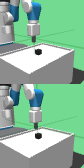

In [10]:
# Sample one transition
sample = test_buffer.sample(1)
observations = sample.observations.float() / 255
next_observations = sample.next_observations.float() / 255
actions = sample.actions

# Predict the action
inverse_model.eval()
pred_actions = inverse_model(observations, next_observations)

# See the result
print("true action\t\t", actions)
print("predicted action\t", pred_actions)

x = torch.dstack((sample.observations, sample.next_observations)).squeeze()
print(x.shape)
im = Image.fromarray(x.moveaxis(0, 2).detach().cpu().numpy())
display(im)
